Loading the data (I had some problems with downloading data from dropbox with wget so I uploaded it on my students website and downloaded it from there) and model visualization.

In [ ]:
!wget students.mimuw.edu.pl/~ps394742/gsn/gsn_img_uint8.npy -O train_data.npy
!wget students.mimuw.edu.pl/~ps394742/gsn/gsn_msk_uint8.npy -O train_labels.npy
!wget students.mimuw.edu.pl/~ps394742/gsn/test_gsn_image.npy -O valid_data.npy
!wget students.mimuw.edu.pl/~ps394742/gsn/test_gsn_mask.npy -O valid_labels.npy
!wget students.mimuw.edu.pl/~ps394742/gsn/gsn_eval_images.npy -O final_data.npy
!wget students.mimuw.edu.pl/~ps394742/gsn/gsn_eval_masks.npy -O final_labels.npy
!wget students.mimuw.edu.pl/~ps394742/gsn/gsn_dev_images.npy -O test_data.npy
!wget students.mimuw.edu.pl/~ps394742/gsn/gsn_dev_masks.npy -O test_labels.npy
!wget students.mimuw.edu.pl/~ps394742/model.png

--2020-06-03 11:41:16--  http://students.mimuw.edu.pl/~ps394742/gsn/gsn_img_uint8.npy
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98304128 (94M)
Saving to: ‘train_data.npy’

train_data.npy      100%[===================>]  93.75M  15.2MB/s    in 5.6s    

2020-06-03 11:41:22 (16.9 MB/s) - ‘train_data.npy’ saved [98304128/98304128]

--2020-06-03 11:41:23--  http://students.mimuw.edu.pl/~ps394742/gsn/gsn_msk_uint8.npy
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32768128 (31M)
Saving to: ‘train_labels.npy’

train_labels.npy    100%[===================>]  31.25M  8.93MB/s    in 3.7s    

2020-06-03 11:41:27 (8

Imports and training parameters.

In [ ]:
import torch 
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys 
from random import random
from IPython.display import Image, display

b_size = 20
num_epochs = 15

In [ ]:
train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')
valid_data = np.load('valid_data.npy')
valid_labels = np.load('valid_labels.npy')


test_data = np.load('test_data.npy')
test_labels = np.load('test_labels.npy')
final_data = np.load('final_data.npy')
final_labels = np.load('final_labels.npy')

train_data.shape

(2000, 128, 128, 3)

Transformations for augmentation. There are 10 transformations in total, those are different roatations, symmetires, shifts and colour changes. During shift the rest of picture is padded with zeros. That ensures there is no meaningful information for classifier in that part of picture.

In [ ]:
#Assumes tensor of shape [num_channels, height, width]
def horizontal_symmetry(tensor):
  return torch.flip(tensor, dims=[2])

def vertical_symmetry(tensor):
  return torch.flip(tensor, dims=[1])

def rotate90(tensor):
  return torch.rot90(tensor, dims = [1, 2])

def rotate270(tensor):
  return torch.rot90(tensor, dims = [2, 1])

def right_shift(tensor):
  res = torch.roll(tensor, 10, dims=[2])
  # pad the cut part with zeros, that means no meaningful information on image and masked pixels on mask
  res[:,:,:10] = torch.zeros((res.shape[0], res.shape[1], 10)) 
  return res

def down_shift(tensor):
  res = torch.roll(tensor, 10, dims=[1])
  # pad the cut part with zeros, that means no meaningful information on image and masked pixels on mask
  res[:,:10,:] = torch.zeros((res.shape[0], 10, res.shape[2])) 
  return res

def left_shift(tensor):
  res = torch.roll(tensor, -10, dims=[2])
  # pad the cut part with zeros, that means no meaningful information on image and masked pixels on mask
  res[:,:,-10:] = torch.zeros((res.shape[0], res.shape[1], 10)) 
  return res

def up_shift(tensor):
  res = torch.roll(tensor, -10, dims=[1])
  # pad the cut part with zeros, that means no meaningful information on image and masked pixels on mask
  res[:,-10:,:] = torch.zeros((res.shape[0], 10, res.shape[2])) 
  return res

def colour_upshift(tensor):
  return torch.clamp(tensor + 0.4, -1, 1)

def colour_downshift(tensor):
  return torch.clamp(tensor - 0.4, -1, 1)

Self-augmentation algorithm. Each picture is transformed in all possible way, and then after passing it to the model reversed transformation is applied.  Also, I took care of the cut parts of shifted images, so they do not count to the pixel accuracy .

In [ ]:
def apply_to_batch(fn, tensor):
  res = torch.zeros_like(tensor)
  for i in range(tensor.shape[0]):
    res[i] = fn(tensor[i])

  return res

# shape of images: [batch_size, num_channels, height, width]
def self_augmentation(net, images):
  device = torch.device('cuda')
  weights = torch.zeros((images.shape[0], 1, images.shape[2], images.shape[3]), device=device)
  tot_prob = torch.zeros_like(weights, device=device)

  # 10 transformations + identity
  im_horizontal_symmetry = apply_to_batch(horizontal_symmetry, images)
  im_vertical_symmetry = apply_to_batch(vertical_symmetry, images)
  im_rotate90 = apply_to_batch(rotate90, images)
  im_rotate270 = apply_to_batch(rotate270, images)
  im_right_shift = apply_to_batch(right_shift, images)
  im_up_shift = apply_to_batch(up_shift, images)
  im_left_shift = apply_to_batch(left_shift, images)
  im_down_shift = apply_to_batch(down_shift, images)
  im_colour_upshift = apply_to_batch(colour_upshift, images)
  im_colour_downshift = apply_to_batch(colour_downshift, images)

  # Account for all transformations
  weights += 11

  # We don't want to count zeros that are added in cut parts of image to the average,
  # so we modify weights to get correct mean
  
  # Accounts for leftshift
  weights[:,:,:,:10] -= 1

  #Accounts for rightshift`
  weights[:,:,:,-10:] -= 1

  # Accounts for upshift
  weights[:,:,:10,:] -= 1

  #Accounts for downshift`
  weights[:,:,-10:,:] -= 1
  
  out = net(images)
  out_horizontal_symmetry = net(im_horizontal_symmetry)
  out_vertical_symmetry = net(im_vertical_symmetry)
  out_rotate90 = net(im_rotate90)
  out_rotate270 = net(im_rotate270)
  out_right_shift = net(im_right_shift)
  out_up_shift = net(im_up_shift)
  out_left_shift = net(im_left_shift)
  out_down_shift = net(im_down_shift)
  out_colour_upshift = net(im_colour_upshift)
  out_colour_downshift = net(im_colour_downshift)

  tot_prob += out
  tot_prob += out_colour_downshift
  tot_prob += out_colour_upshift
  # inverse transformations where neccessary
  tot_prob += apply_to_batch(horizontal_symmetry, out_horizontal_symmetry)
  tot_prob += apply_to_batch(vertical_symmetry, out_vertical_symmetry)
  tot_prob += apply_to_batch(rotate270, out_rotate90)
  tot_prob += apply_to_batch(rotate90, out_rotate270)
  # note that reverse shift gives zero predictions for the part of image that was cut
  tot_prob += apply_to_batch(left_shift, out_right_shift)
  tot_prob += apply_to_batch(right_shift, out_left_shift)
  tot_prob += apply_to_batch(down_shift, out_up_shift)
  tot_prob += apply_to_batch(up_shift, out_down_shift)

  probs = tot_prob / weights

  return  probs

Composition of random transformations. Each transformation has 9% chances to be applied (10% chances for no transformation). I decided to avoid applying transformations with independent probabilities since composition of many transformations makes the result image less readable (and without compositions training task resembles more the task during evaluation with self-augmentation involved).

In [ ]:
def apply_transformations(image, mask):
  r = random()

  if (r < 0.09):
    image = horizontal_symmetry(image)
    mask = horizontal_symmetry(mask)

  elif (r < 0.18):
    image = vertical_symmetry(image)
    mask = vertical_symmetry(mask)

  elif (r < 0.27):
    image = rotate90(image)
    mask = rotate90(mask)
  
  elif (r < 0.36):
    image = rotate270(image)
    mask = rotate270(mask)   
  
  elif (r < 0.45):
    image = right_shift(image)
    mask = right_shift(mask)
  
  elif(r < 0.54):
    image = left_shift(image)
    mask = left_shift(mask)

  elif (r < 0.63):
    image = up_shift(image)
    mask = up_shift(mask)
  
  elif(r < 0.72):
    image = down_shift(image)
    mask = down_shift(mask)  
  
  elif (r < 0.81):
    image = colour_upshift(image)
  
  elif(r < 0.9):
    image = colour_downshift(image)  


  return image, mask

Type od dataset for semantic segmentation with data augmentation for training. Creates dataloader from provided numpy arrays.

In [ ]:
class SegDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks, augmentation=True):
        self.images = images
        self.masks = masks
        self.len = self.images.shape[0]
        self.augmentation = augmentation

    def transform(self, image, mask):
        image = image.astype('float64')
        mask = mask.astype('float64')
        image = torchvision.transforms.ToTensor()(image)
        mask = torchvision.transforms.ToTensor()(mask)
        image = torchvision.transforms.Normalize((127.5,127.5,127.5), (127.5,127.5,127.5))(image)
        mask = mask / 255.

        if(self.augmentation):
          image, mask = apply_transformations(image, mask)
        
        return image, mask

    def __getitem__(self, index):
        image, mask = self.transform(self.images[index], self.masks[index])
        return image, mask

    def __len__(self):
        return self.len

In [ ]:
trainset = SegDataset(train_data, train_labels, augmentation=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=0)

I displayed some pictures and masks to understand better what the task is about. As we can see, the aim of segmentation task is to find person on image.

torch.Size([16, 3, 128, 128])


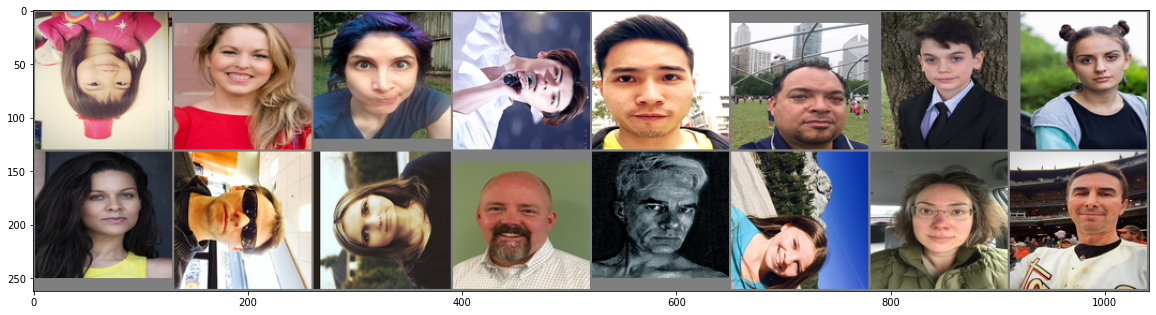

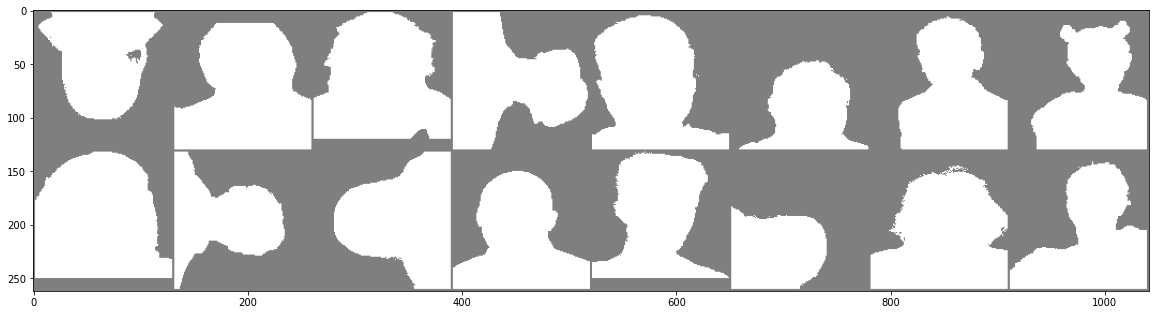

In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.figure(figsize=(20,10))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, masks = dataiter.next()

print(images.shape)
images = torchvision.utils.make_grid(images)
masks = torchvision.utils.make_grid(masks)
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(masks))

The code for model is sometimes more parametrized than neccessary. It is because I tried different parameteters (e.g layers sizes, upsampling algorithms. I decided to leave the code as it is so one can easily change model parameters.

Modules used to build the U-Net: 

1. Convolution module. It applies twice the set of operations: convolution + batch normalization + relu activation. 

In [ ]:
class ConvNet(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super(ConvNet, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size

    # Padding is added so the size of layer does not change.
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=int((kernel_size - 1) / 2))
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=int((kernel_size - 1) / 2))
    self.batchNorm = nn.BatchNorm2d(out_channels)
    

  def forward(self, x):
    x = self.conv(x)
    x = self.batchNorm(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = self.batchNorm(x)
    x = F.relu(x)
    return x

  2. Module for downsampling. Applies pooling and then the double convolution described above

In [ ]:
class DownNet(nn.Module):
  def __init__(self, pooling_size, in_channels, out_channels, kernel_size):
    super(DownNet, self).__init__()
    self.pooling_size = pooling_size
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size

    self.pool = nn.MaxPool2d(pooling_size)
    self.conv = ConvNet(in_channels, out_channels, kernel_size)    

  def forward(self, x):
    x = self.pool(x)
    x = self.conv(x)
    return x 

  3. Module for upsampling. Applies chosen upsampling algorithm (bilinear upsampling, nearest unpooling or deconvolution) and then aplies double convolution from point 1.

In [ ]:
# mode = 'deconv', 'bilinear' or 'nearest' 
# skip = 'sum' or 'cat'
class UpNet(nn.Module):
  def __init__(self, mode, scale_factor, in_channels, out_channels, kernel_size, skip):
    super(UpNet, self).__init__()
    self.mode = mode
    self.scale_factor = scale_factor
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.skip = skip

    self.deconv = nn.ConvTranspose2d(in_channels - out_channels , in_channels - out_channels, kernel_size=scale_factor, stride=scale_factor)
    self.bilinear = nn.Upsample(scale_factor=scale_factor, mode='bilinear')
    self.nearest = nn.Upsample(scale_factor=scale_factor, mode='nearest')
    self.conv = ConvNet(in_channels, out_channels, kernel_size)    

  def forward(self, x, y):
    if self.mode == 'deconv':
      x = self.deconv(x)
    elif self.mode == 'bilinear':
      x = self.bilinear(x)
    elif self.mode == 'nearest':
      x = self.nearest(x)
    else:
      sys.exit('bad mode of upsampling layer')
    
    if self.skip == 'cat':
      x = torch.cat([x, y], dim=1)
    
    # Here we assume x and y have the same number of channels
    elif self.skip == 'sum':
      x = x + y

    else:
      sys.exit('bad skip connection type for upsampling layer')  

    x = self.conv(x)
    return x 

U-Net model:

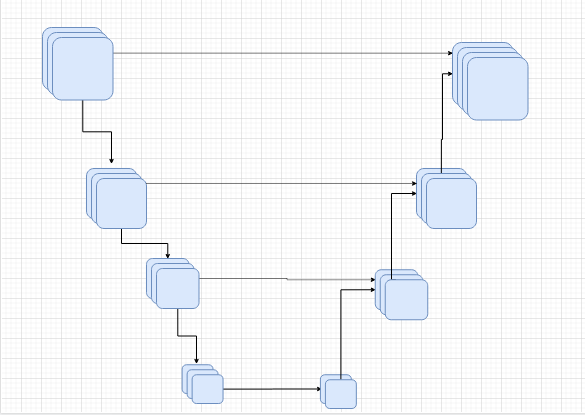

In [ ]:
display(Image('model.png'))

This model is very similar to the original U-Net model for medical segmentation (https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/). I didn't put numbers on the image because they were not readable, so I present detailed description below.

1. On first level each image has size of 128x128, the number of channels after applying first two convolutions changes from 3 to 16 (3 -> 16 -> 16).

2. Second level: size of images is 64x64, changes in number of channels: 16 -> 32 -> 32. 

3. Third level: size of images is 32x32, numbers of channels: 32 -> 64 -> 64

4. Bottom level size of images is 32x32, nubmers of channels 64 -> 128 -> 128. After that another double-convolution is applied (it does not change channels number).

5. Third level again. Output from point 3 goes through skip connection and is concatenated with upsampled (in bilinear mode) output from bottom layer. That gives 192-channel layer of size 32x32. Then double convolution is applied and channel number is decreased: 192 -> 64 -> 64.

6. Second level. Analogical to the description above, the number of channels changes in the following way: (64+32=96-> 32 -> 32)

7. First level. Same as above. Channel numbers: (32+16=48) -> 16 -> 16. At the end single convolution is added that reduces the number of channels to 1 which procudes the activations of the model. After that sigmoid is used to change activations to probabilites. The loss function is binary cross-entropy loss.

In my final solution I use bilinear upsampling when going upwards and concatenation when merging the results from skip connections and lower levels.

In [ ]:
class U_Net(nn.Module):
  def __init__(self, mode, skip):
    super(U_Net, self).__init__()
    self.mode = mode
    self.skip = skip

    self.begConv = ConvNet(3, 16, 5)
    self.down1 = DownNet(2, 16, 32, 3)
    self.down2 = DownNet(2, 32, 64, 3)
    self.down3 = DownNet(2, 64, 128, 3)
    self.midConv = ConvNet(128, 128, 3)
    self.up3 = UpNet(mode, 2, 192, 64, 3, skip)
    self.up2 = UpNet(mode, 2, 96, 32, 3, skip)
    self.up1 = UpNet(mode, 2, 48, 16, 3, skip)
    # Without batchnorm and relu
    self.lastConv = nn.Conv2d(16, 1, 5, padding = 2)

  def forward(self, x): 
    skip1 = self.begConv(x)
    skip2 = self.down1(skip1)
    skip3 = self.down2(skip2)
    x = self.down3(skip3)
    x = self.midConv(x)
    x = self.up3(x, skip3)
    x = self.up2(x, skip2)
    x = self.up1(x, skip1)
    x = self.lastConv(x)
    x = F.sigmoid(x)

    return x

criterion = nn.BCELoss()
analysis_criterion = nn.BCELoss(reduction='none')
net = U_Net('bilinear', 'cat')

Functions for evaluation and analysis: pixel accuracy, intersection under union metric and pixel entropy.

In [ ]:
def accuracy(preds, labels):
  total = preds.numel() / preds.shape[0]
  correct = (preds == labels).float().sum((1,2,3))
  return 100 * correct / total

def intersection_over_union(preds, labels):
  # eps is added in case union is empty, so we do not divide by 0.
  eps = 1e-6
  intersection = (preds.int() & labels.int()).float().sum((1,2,3))
  union = (preds.int() | labels.int()).float().sum((1,2,3))
  iou = (intersection + eps) / (union + eps)
  return 100 * iou

def pixel_entropies(outputs):
  ent = -outputs * torch.log2(outputs)
  res = ent.mean((1,2,3))
  return res

The following code performes experiment given model and augmentation parameter (True = do augmentation during training and self-agumentation during evaluation, False = don't).

In [ ]:
def mean(list):
  return sum(list) / len(list)

def perform_experiment(net, augmentation):
  net.cuda()
  optimizer = torch.optim.Adam(net.parameters())

  trainset = SegDataset(train_data, train_labels, augmentation=augmentation)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=b_size, shuffle=True, num_workers=0)

  validset = SegDataset(valid_data, valid_labels, augmentation=False)
  validloader = torch.utils.data.DataLoader(validset, batch_size=b_size, shuffle=True, num_workers=0)

  # collect results among epochs
  losses = []
  epoch_ious = []
  epoch_accuracies = []

  for epoch in range(25):
    print('Epoch: ' , epoch + 1)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i * b_size % 200 < b_size and i > 0): 
            loss_per_batch = running_loss * b_size / 200
            # losses keep mean loss per batch
            losses.append(loss_per_batch)
            print('step %d loss: %.3f' %
                  (i * b_size, loss_per_batch))
            running_loss = 0.0

    # collect results for single epoch
    temp_accuracies = []
    temp_ious = []
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images = images.float()
            labels = labels.float()
            images = images.cuda()
            labels = labels.cuda()
            outputs = torch.zeros_like(labels)

            if augmentation:
              outputs = self_augmentation(net, images)

            else:
              outputs = net(images)

            predicted = (outputs.data - 0.5).ceil()
            accs = accuracy(predicted, labels)
            ious = intersection_over_union(predicted, labels)
            
            temp_ious.extend(ious)
            temp_accuracies.extend(accs)
    
        # epoch_accuracies and epoch_ious keep cumulated results for each epoch
        mean_iou = mean(temp_ious)
        mean_acc = mean(temp_accuracies)
        epoch_ious.append(mean_iou)
        epoch_accuracies.append(mean_acc)

    print('Accuracy on validation set: %.2f %%' % (mean_acc))
    print('IOU on validation set: %.2f %%' %(mean_iou))

  return losses, epoch_accuracies, epoch_ious

The code below is used to collect information neccessary for analysis. Those are: accuracy metrics, pixel_entropy, losses on training and evaluation sets and corresponding images.

In [ ]:
def perform_analysis(net, augmentation):
  net.cuda()

  # We do not need to shuffle the data during analysis
  trainset = SegDataset(train_data, train_labels, augmentation=augmentation)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=b_size, shuffle=False, num_workers=0)

  validset = SegDataset(valid_data, valid_labels, augmentation=False)
  validloader = torch.utils.data.DataLoader(validset, batch_size=b_size, shuffle=False, num_workers=0)

  # collect results for analysis
  train_images = []
  valid_images = []
  train_losses = []
  valid_losses = []
  valid_accuracies = []
  valid_entropies = []
  valid_ious = []

  with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = net(inputs)
        losses = analysis_criterion(outputs, labels)
        losses = losses.mean((1,2,3))
        
        train_images.extend(inputs)
        train_losses.extend(losses)


    for data in validloader:
        images, labels = data
        images = images.float()
        labels = labels.float()
        images = images.cuda()
        labels = labels.cuda()
        valid_images.extend(images)
        outputs = net(images)

        losses = analysis_criterion(outputs, labels)
        losses = losses.mean((1,2,3))
        entropies = pixel_entropies(outputs)
        
        predicted = (outputs.data - 0.5).ceil()
        accs = accuracy(predicted, labels)
        ious = intersection_over_union(predicted, labels)
        
        valid_losses.extend(losses)
        valid_accuracies.extend(accs)
        valid_entropies.extend(entropies)
        valid_ious.extend(ious)

  return train_images, valid_images, train_losses, valid_losses, valid_accuracies, valid_entropies, valid_ious

Experiments: as we see, the model gets accuracy of over 90% after 15 epochs of training. What's interesting, the augmentation and self-augmentation techniques do not seem to help too much (in fact, each new transformation reduces slightly model accuracy).

In [ ]:
u_net = U_Net('bilinear', 'cat')
losses, epoch_accuracies, epoch_ious = perform_experiment(net=u_net, augmentation=True)

Epoch:  1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


step 200 loss: 0.643
step 400 loss: 0.493
step 600 loss: 0.443
step 800 loss: 0.411
step 1000 loss: 0.461
step 1200 loss: 0.418
step 1400 loss: 0.423
step 1600 loss: 0.379
step 1800 loss: 0.399
Accuracy on validation set: 81.67 %
IOU on validation set: 73.38 %
Epoch:  2
step 200 loss: 0.426
step 400 loss: 0.377
step 600 loss: 0.396
step 800 loss: 0.347
step 1000 loss: 0.331
step 1200 loss: 0.340
step 1400 loss: 0.339
step 1600 loss: 0.374
step 1800 loss: 0.366
Accuracy on validation set: 84.60 %
IOU on validation set: 76.95 %
Epoch:  3
step 200 loss: 0.352
step 400 loss: 0.352
step 600 loss: 0.326
step 800 loss: 0.330
step 1000 loss: 0.290
step 1200 loss: 0.325
step 1400 loss: 0.283
step 1600 loss: 0.312
step 1800 loss: 0.299
Accuracy on validation set: 86.77 %
IOU on validation set: 78.79 %
Epoch:  4
step 200 loss: 0.300
step 400 loss: 0.264
step 600 loss: 0.252
step 800 loss: 0.267
step 1000 loss: 0.279
step 1200 loss: 0.255
step 1400 loss: 0.290
step 1600 loss: 0.247
step 1800 loss:

We can copmare there results to net trained without augmentation and self augmentation. The results are a bit better: model reaches about 94% accuracy and about 89% IOU.

In [ ]:
no_aug = U_Net('bilinear', 'cat')
losses, epoch_accuracies, epoch_ious = perform_experiment(net=no_aug, augmentation=False)

Epoch:  1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


step 200 loss: 0.553
step 400 loss: 0.371
step 600 loss: 0.330
step 800 loss: 0.296
step 1000 loss: 0.283
step 1200 loss: 0.249
step 1400 loss: 0.236
step 1600 loss: 0.275
step 1800 loss: 0.252
Accuracy on validation set: 87.46 %
IOU on validation set: 80.36 %
Epoch:  2
step 200 loss: 0.234
step 400 loss: 0.202
step 600 loss: 0.194
step 800 loss: 0.194
step 1000 loss: 0.209
step 1200 loss: 0.198
step 1400 loss: 0.192
step 1600 loss: 0.212
step 1800 loss: 0.167
Accuracy on validation set: 89.06 %
IOU on validation set: 82.13 %
Epoch:  3
step 200 loss: 0.193
step 400 loss: 0.163
step 600 loss: 0.169
step 800 loss: 0.163
step 1000 loss: 0.150
step 1200 loss: 0.141
step 1400 loss: 0.153
step 1600 loss: 0.161
step 1800 loss: 0.165
Accuracy on validation set: 89.81 %
IOU on validation set: 83.69 %
Epoch:  4
step 200 loss: 0.150
step 400 loss: 0.138
step 600 loss: 0.128
step 800 loss: 0.113
step 1000 loss: 0.151
step 1200 loss: 0.140
step 1400 loss: 0.151
step 1600 loss: 0.157
step 1800 loss:

The code below runs function neccessary for analysis:

In [ ]:
train_images, valid_images, train_losses, valid_losses, valid_accuracies, valid_entropies, valid_ious = perform_analysis(net=u_net, augmentation=True)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


The code below visualizes 8 exapmles with the highest loss in training and validation sets (the examples from training set are transformed with augmentation functions). One can see that following features make the image a hard sample:

1. The backgroud has simmilar colour to skin, hair or clothing.
2. Person on the picture has different skin colour.
3. Some parts of faces are covered or the picture is in such resolution that the head seems to have unnatural shape.

The samples from validation set look particuraly unnatural (people are mostly copy-pasted on the image).

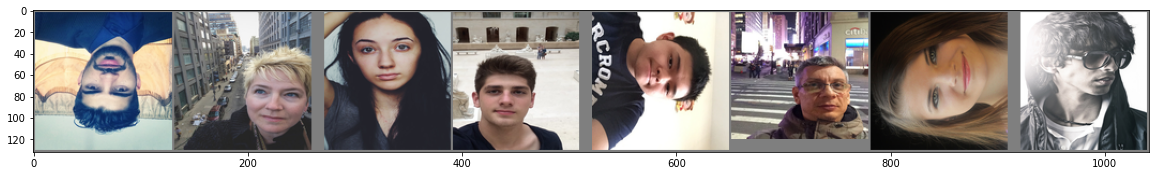

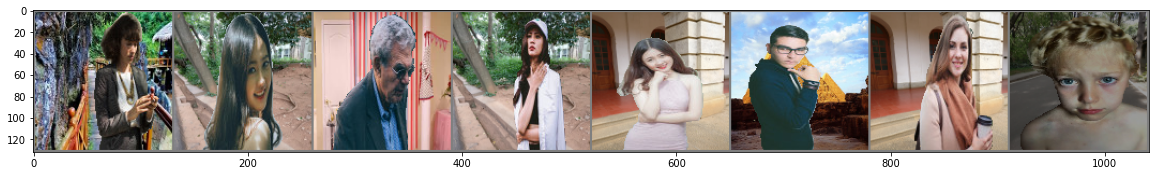

In [ ]:
# Choose 8 images with highest loss from training and validation sets
indexed_valid_losses = [(val, i) for i, val in enumerate(valid_losses)]
indexed_train_losses = [(val, i) for i, val in enumerate(train_losses)]
indexed_valid_losses = sorted(indexed_valid_losses, reverse=True)
indexed_train_losses = sorted(indexed_train_losses, reverse=True)

high_valid_loss_idx = []
high_train_loss_idx = []

for i in range(8):
  high_valid_loss_idx.append(indexed_valid_losses[i][1])
  high_train_loss_idx.append(indexed_train_losses[i][1])

high_valid_loss = []
high_train_loss = []

for (i,j) in zip(high_valid_loss_idx, high_train_loss_idx):
  high_valid_loss.append(valid_images[i])
  high_train_loss.append(train_images[i])

high_valid_loss = torch.stack(tuple(high_valid_loss))
high_train_loss = torch.stack(tuple(high_train_loss))

high_valid_loss = torchvision.utils.make_grid(high_valid_loss)
high_train_loss = torchvision.utils.make_grid(high_train_loss)

high_valid_loss = high_valid_loss.cpu()
high_train_loss = high_train_loss.cpu()

imshow(torchvision.utils.make_grid(high_train_loss))
imshow(torchvision.utils.make_grid(high_valid_loss))

The code below shows relation between pixel entropy and evaluation metrics (pixel accuracy with blue and intersection over union with orange). 

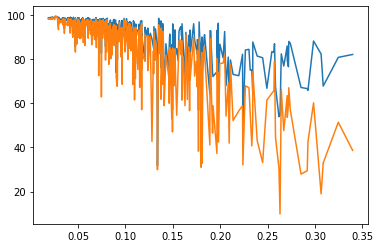

In [ ]:
# Sort accuracies by classifier confidence
indexed_entropies = [(val, i) for i, val in enumerate(valid_entropies)]
indexed_entropies = sorted(indexed_entropies)

valid_accuracies = [valid_accuracies[i].item() for (_,i) in indexed_entropies] 
valid_ious = [valid_ious[i].item() for (_,i) in indexed_entropies]
valid_entropies = sorted(valid_entropies)

plt.plot(valid_entropies, valid_accuracies,
         valid_entropies, valid_ious)


The plot above is a bit noisy so I decided to make it a bit more smooth.
Now we can see that pixel accuracy and intercecion under union metric decrease substantially when pixel entropy gets bigger. This seems to be natural since high pixel entropy means that classifier is less confident about it's guesses so it makes more mistakes (IOU with orange colour, accuracy with blue).

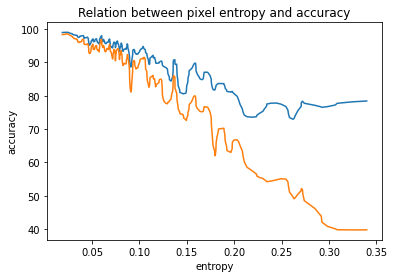

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d

acc_smoothed = gaussian_filter1d(valid_accuracies, sigma=3)
iou_smoothed = gaussian_filter1d(valid_ious, sigma=3)

plt.title('Relation between pixel entropy and accuracy')
plt.xlabel('entropy')
plt.ylabel('accuracy')

plt.plot(valid_entropies, acc_smoothed,
         valid_entropies, iou_smoothed)

I also wanted to submit Fast_Net for the fatest model competition. To create it I changed everywhere double convolutions to single convolutions, removed one level from U-Net, decreased kernel sizes, and increased pooling parameters to make lower layers smaller.

Below is the code for modules and Fast_Net (fast version of U_Net) architecutre.

In [ ]:
class FastConvNet(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super(FastConvNet, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size

    # Padding is added so the size of layer does not change.
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=int((kernel_size - 1) / 2))
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=int((kernel_size - 1) / 2))
    self.batchNorm = nn.BatchNorm2d(out_channels)
    

  def forward(self, x):
    x = self.conv(x)
    x = self.batchNorm(x)
    x = F.relu(x)
    # x = self.conv2(x)
    # x = self.batchNorm(x)
    # x = F.relu(x)
    return x

In [ ]:
class FastDownNet(nn.Module):
  def __init__(self, pooling_size, in_channels, out_channels, kernel_size):
    super(FastDownNet, self).__init__()
    self.pooling_size = pooling_size
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size

    self.pool = nn.MaxPool2d(pooling_size)
    self.conv = FastConvNet(in_channels, out_channels, kernel_size)    

  def forward(self, x):
    x = self.pool(x)
    x = self.conv(x)
    return x 

In [ ]:
# mode = 'deconv', 'bilinear' or 'nearest' 
# skip = 'sum' or 'cat'
class FastUpNet(nn.Module):
  def __init__(self, mode, scale_factor, in_channels, out_channels, kernel_size, skip):
    super(FastUpNet, self).__init__()
    self.mode = mode
    self.scale_factor = scale_factor
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.skip = skip

    self.deconv = nn.ConvTranspose2d(in_channels - out_channels , in_channels - out_channels, kernel_size=scale_factor, stride=scale_factor)
    self.bilinear = nn.Upsample(scale_factor=scale_factor, mode='bilinear')
    self.nearest = nn.Upsample(scale_factor=scale_factor, mode='nearest')
    self.conv = FastConvNet(in_channels, out_channels, kernel_size)    

  def forward(self, x, y):
    if self.mode == 'deconv':
      x = self.deconv(x)
    elif self.mode == 'bilinear':
      x = self.bilinear(x)
    elif self.mode == 'nearest':
      x = self.nearest(x)
    else:
      sys.exit('bad mode of upsampling layer')
    
    if self.skip == 'cat':
      x = torch.cat([x, y], dim=1)
    
    # Here we assume x and y have the same number of channels
    elif self.skip == 'sum':
      x = x + y

    else:
      sys.exit('bad skip connection type for upsampling layer')  

    x = self.conv(x)
    return x 

In [ ]:
class Fast_Net(nn.Module):
  def __init__(self, mode, skip):
    super(Fast_Net, self).__init__()
    self.mode = mode
    self.skip = skip

    self.begConv = FastConvNet(3, 10, 3)
    self.down1 = FastDownNet(4, 10, 20, 3)
    self.down2 = FastDownNet(4, 20, 40, 3)
    # self.down3 = DownNet(2, 64, 128, 3)
    self.midConv = FastConvNet(40, 40, 1)
    # self.up3 = UpNet(mode, 2, 192, 64, 3, skip)
    self.up2 = FastUpNet(mode, 4, 60, 20, 3, skip)
    self.up1 = FastUpNet(mode, 4, 30, 10, 3, skip)
    # Without batchnorm and relu
    self.lastConv = nn.Conv2d(10, 1, 5, padding = 2)

  def forward(self, x): 
    skip1 = self.begConv(x)
    skip2 = self.down1(skip1)
    x = self.down2(skip2)
    # x = self.down3(skip3)
    x = self.midConv(x)
    # x = self.up3(x, skip3)
    x = self.up2(x, skip2)
    x = self.up1(x, skip1)
    x = self.lastConv(x)
    x = F.sigmoid(x)

    return x

The following code was used to run this net for 15 epochs:

In [ ]:
fast_net = Fast_Net('bilinear', 'cat')
losses, epoch_accuracies, epoch_ious = perform_experiment(net=fast_net, augmentation=False)

Sample code to perform evaluation.

In [ ]:
def evaluate(net):
  validset = SegDataset(final_data, final_labels, augmentation=False)
  validloader = torch.utils.data.DataLoader(validset, batch_size=50, shuffle=False, num_workers=0)
  
  temp_accuracies = []
  # temp_ious = []
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images = images.float()
          labels = labels.float()
          images = images.cuda()
          labels = labels.cuda()
          outputs = torch.zeros_like(labels)

          outputs = net(images)

          predicted = (outputs.data - 0.5).ceil()
          accs = accuracy(predicted, labels)
          # ious = intersection_over_union(predicted, labels)
          temp_accuracies.extend(accs)
          # temp_ious.extend(ious)

  
      # mean_iou = mean(temp_ious)
      mean_acc = mean(temp_accuracies)


  print('Accuracy on validation set: %.2f %%' % (mean_acc))
  # print('IOU on validation set: %.2f %%' % (mean_iou))

Saving model parameters:

In [ ]:
torch.save(fast_net.state_dict(), "fast_net")

To make the results deterministic I saved one model my own and uploaded it at my students site, one can download it with the following code:

In [ ]:
!wget students.mimuw.edu.pl/~ps394742/fast_net
fast_net = Fast_Net('bilinear', 'cat')
fast_net.load_state_dict(torch.load('fast_net'))
fast_net.cuda()
fast_net.eval()
print('done')

--2020-06-03 11:46:55--  http://students.mimuw.edu.pl/~ps394742/fast_net
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 340380 (332K)
Saving to: ‘fast_net.1’

fast_net.1          100%[===================>] 332.40K  --.-KB/s    in 0.09s   

2020-06-03 11:46:55 (3.69 MB/s) - ‘fast_net.1’ saved [340380/340380]

done


Now we can meassure time and evaluate fast model. As we see, it reaches accuracy over 90% and goes through alll validation set in under 0.6 seconds.

In [ ]:
import time
start_time = time.time()
evaluate(fast_net)
end_time = time.time()
print(end_time - start_time)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy on validation set: 94.00 %
2.408888339996338


I also saved parameters for the model with best IOU:

In [ ]:
torch.save(no_aug.state_dict(), "no_aug")

And uploaded it on students site, to get the model run following code:

In [ ]:
!wget students.mimuw.edu.pl/~ps394742/best_net
best_net = U_Net('bilinear', 'cat')
best_net.load_state_dict(torch.load('best_net'))
best_net.cuda()
print('done')
evaluate(best_net)

--2020-06-03 11:16:11--  http://students.mimuw.edu.pl/~ps394742/best_net
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3517460 (3.4M)
Saving to: ‘best_net.1’

best_net.1          100%[===================>]   3.35M  7.60MB/s    in 0.4s    

2020-06-03 11:16:11 (7.60 MB/s) - ‘best_net.1’ saved [3517460/3517460]

done


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy on validation set: 96.92 %
IOU on validation set: 94.58 %
